In [1]:
import json
import sklearn
import requests
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from __future__ import division
import tensorflow as tf
import numpy as np
import tarfile
import os
import json
import matplotlib.pyplot as plt
import time

In [2]:
with open("./data/zenodo_open_metadata_06_04_2017_cleaned_20_08_17.json", "r") as fp:
    data = json.load(fp)
labels = [d['spam'] for d in data]

In [3]:
def feat_tr(d):
    return d['description'] + d['title']

X = [feat_tr(d) for d in data]
y = np.array([[1 if d['spam'] else 0, 1 if not d['spam'] else 0] for d in data])

ngram_range=(1, 1)
count_vect = CountVectorizer(ngram_range=ngram_range, max_features=8000)
tfid = TfidfTransformer()
X_v = count_vect.fit_transform(X)
X_v = tfid.fit_transform(X_v)

In [73]:
X_v

<183998x8000 sparse matrix of type '<class 'numpy.float64'>'
	with 7317180 stored elements in Compressed Sparse Row format>

In [4]:
trainX, testX, trainY, testY = train_test_split(X_v, np.asarray(y, dtype=np.float32), test_size=3000, train_size=6000, random_state=42)

In [22]:
#trX_idx, tsX_idx, trY_idx, tsY_idx = train_test_split(range(X_v.shape[0]),range(X_v.shape[0]), test_size=0.33, random_state=42)

In [8]:
trainX, testX, trainY, testY = train_test_split(X_v, y, test_size=0.33, random_state=42)

In [5]:
trainX = np.asarray(trainX.todense(), dtype=np.float32)
#trainY = trainY
testX = np.asarray(testX.todense(), dtype=np.float32)
#testY = testY

In [6]:
numFeatures = trainX.shape[1]
numLabels = trainY.shape[1]
numEpochs = 27000
# a smarter learning rate for gradientOptimizer
learningRate = tf.train.exponential_decay(learning_rate=0.0008,
                                          global_step= 1,
                                          decay_steps=trainX.shape[0],
                                          decay_rate= 0.95,
                                          staircase=True)

In [7]:
# X = X-matrix / feature-matrix / data-matrix... It's a tensor to hold our email
# data. 'None' here means that we can hold any number of emails
Xtens = tf.placeholder(tf.float32, [None, numFeatures])
# yGold = Y-matrix / label-matrix / labels... This will be our correct answers
# matrix. Every row has either [1,0] for SPAM or [0,1] for HAM. 'None' here 
# means that we can hold any number of emails
yGold = tf.placeholder(tf.float32, [None, numLabels])

In [8]:
# Values are randomly sampled from a Gaussian with a standard deviation of:
#     sqrt(6 / (numInputNodes + numOutputNodes + 1))

weights = tf.Variable(tf.random_normal([numFeatures,numLabels],
                                       mean=0,
                                       stddev=(np.sqrt(6/numFeatures+
                                                         numLabels+1)),
                                       name="weights"))

bias = tf.Variable(tf.random_normal([1,numLabels],
                                    mean=0,
                                    stddev=(np.sqrt(6/numFeatures+numLabels+1)),
                                    name="bias"))

In [9]:
# INITIALIZE our weights and biases
init_OP = tf.initialize_all_variables()

# PREDICTION ALGORITHM i.e. FEEDFORWARD ALGORITHM
apply_weights_OP = tf.matmul(Xtens, weights, name="apply_weights")
add_bias_OP = tf.add(apply_weights_OP, bias, name="add_bias") 
activation_OP = tf.nn.sigmoid(add_bias_OP, name="activation")

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [11]:
cost_OP = tf.nn.l2_loss(activation_OP-yGold, name="squared_error_cost")

In [12]:
training_OP = tf.train.GradientDescentOptimizer(learningRate).minimize(cost_OP)

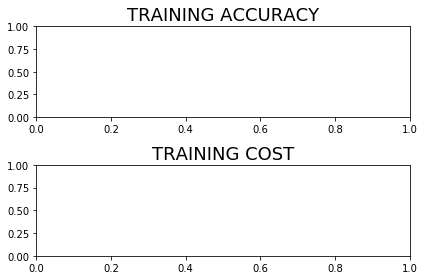

In [13]:
epoch_values=[]
accuracy_values=[]
cost_values=[]
# Turn on interactive plotting
plt.ion()
# Create the main, super plot
fig = plt.figure()
# Create two subplots on their own axes and give titles
ax1 = plt.subplot("211")
ax1.set_title("TRAINING ACCURACY", fontsize=18)
ax2 = plt.subplot("212")
ax2.set_title("TRAINING COST", fontsize=18)
plt.tight_layout()

In [86]:
#####################
### RUN THE GRAPH ###
#####################

# Create a tensorflow session
sess = tf.Session()

# Initialize all tensorflow variables
sess.run(init_OP)

## Ops for vizualization
# argmax(activation_OP, 1) gives the label our model thought was most likely
# argmax(yGold, 1) is the correct label
correct_predictions_OP = tf.equal(tf.argmax(activation_OP,1),tf.argmax(yGold,1))
# False is 0 and True is 1, what was our average?
accuracy_OP = tf.reduce_mean(tf.cast(correct_predictions_OP, "float"))
# Summary op for regression output
activation_summary_OP = tf.summary.histogram("output", activation_OP)
# Summary op for accuracy
accuracy_summary_OP = tf.summary.scalar("accuracy", accuracy_OP)
# Summary op for cost
cost_summary_OP = tf.summary.scalar("cost", cost_OP)
# Summary ops to check how variables (W, b) are updating after each iteration
weightSummary = tf.summary.histogram("weights", weights.eval(session=sess))
biasSummary = tf.summary.histogram("biases", bias.eval(session=sess))
# Merge all summaries
all_summary_OPS = tf.summary.merge_all()
# Summary writer
writer = tf.summary.FileWriter("summary_logs", sess.graph)

# Initialize reporting variables
cost = 0
diff = 1

# Training epochs
for i in range(numEpochs):
    if i > 1 and diff < .0001:
        print("change in cost %g; convergence."%diff)
        break
    else:
        # Run training step
        step = sess.run(training_OP, feed_dict={Xtens: trainX, yGold: trainY})
        # Report occasional stats
        if i % 10 == 0:
            # Add epoch to epoch_values
            epoch_values.append(i)
            # Generate accuracy stats on test data
            summary_results, train_accuracy, newCost = sess.run(
                [all_summary_OPS, accuracy_OP, cost_OP], 
                feed_dict={Xtens: trainX, yGold: trainY}
            )
            # Add accuracy to live graphing variable
            accuracy_values.append(train_accuracy)
            # Add cost to live graphing variable
            cost_values.append(newCost)
            # Write summary stats to writer
            writer.add_summary(summary_results, i)
            # Re-assign values for variables
            diff = abs(newCost - cost)
            cost = newCost

            #generate print statements
            print("step %d, training accuracy %g"%(i, train_accuracy))
            print("step %d, cost %g"%(i, newCost))
            print("step %d, change in cost %g"%(i, diff))
            
            y_res = sess.run(activation_OP, feed_dict={Xtens:testX})
            y_res = list(y_res[:,0] > 0.5)
            y_gold = list(bool(yy) for yy in testY[:,0])
            acc = [(ref, pred) for ref, pred in zip(y_gold, y_res)]
            c = Counter(acc)
            print(c)
            print("S->S:{0:.5f}   H->H:{1:.5f}   Acc:{2:.5f}".format(
                c[(True, True)] / (c[(True, True)] + c[(True, False)]),
                c[(False, False)] / (c[(False, False)] + c[(False, True)]),
                (c[(False, False)] + c[(True, True)]) / (len(acc))
            ))

            # Plot progress to our two subplots
            #accuracyLine, = ax1.plot(epoch_values, accuracy_values)
            #costLine, = ax2.plot(epoch_values, cost_values)
            #fig.canvas.draw()
            #time.sleep(1)


# How well do we perform on held-out test data?
print("final accuracy on test set: %s" %str(sess.run(accuracy_OP, 
                                                     feed_dict={Xtens: testX, 
                                                                yGold: testY})))

InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_2' with dtype float and shape [?,8000]
	 [[Node: Placeholder_2 = Placeholder[dtype=DT_FLOAT, shape=[?,8000], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'Placeholder_2', defined at:
  File "/usr/lib64/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib64/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/alice/env/classifier/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/alice/env/classifier/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/alice/env/classifier/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/alice/env/classifier/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/alice/env/classifier/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/alice/env/classifier/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/alice/env/classifier/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/alice/env/classifier/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/alice/env/classifier/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/alice/env/classifier/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/alice/env/classifier/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/alice/env/classifier/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/alice/env/classifier/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/alice/env/classifier/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/alice/env/classifier/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/alice/env/classifier/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/alice/env/classifier/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/alice/env/classifier/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-63-110ffb262c36>", line 3, in <module>
    Xtens = tf.placeholder(tf.float32, [None, numFeatures])
  File "/home/alice/env/classifier/lib/python3.5/site-packages/tensorflow/python/ops/array_ops.py", line 1548, in placeholder
    return gen_array_ops._placeholder(dtype=dtype, shape=shape, name=name)
  File "/home/alice/env/classifier/lib/python3.5/site-packages/tensorflow/python/ops/gen_array_ops.py", line 2094, in _placeholder
    name=name)
  File "/home/alice/env/classifier/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/alice/env/classifier/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/alice/env/classifier/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder_2' with dtype float and shape [?,8000]
	 [[Node: Placeholder_2 = Placeholder[dtype=DT_FLOAT, shape=[?,8000], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [33]:
# How well do we perform on held-out test data?
print("final accuracy on test set: %s" %str(sess.run(accuracy_OP, 
                                                     feed_dict={Xtens: testX,
                                                                yGold: testY})))

final accuracy on test set: 0.968667


In [46]:
y_res = sess.run(activation_OP, feed_dict={Xtens:testX})

In [47]:
y_res

array([[  2.18718033e-02,   9.99434531e-01],
       [  1.37939496e-04,   9.99366581e-01],
       [  2.09738524e-03,   9.99402523e-01],
       ..., 
       [  5.48261276e-04,   9.96171772e-01],
       [  1.03792008e-02,   9.98052597e-01],
       [  1.42262306e-03,   9.98476326e-01]], dtype=float32)

In [48]:
y_res = list(y_res[:,0] > 0.5)

In [49]:
y_gold = list(bool(yy) for yy in testY[:,0])

In [55]:
acc = [(ref, pred) for ref, pred in zip(y_gold, y_res)]
c = Counter(acc)
print("S->S:{0:.5f}   H->H:{1:.5f}   Acc:{2:.5f}".format(
    c[(True, True)] / (c[(True, True)] + c[(True, False)]),
    c[(False, False)] / (c[(False, False)] + c[(False, True)]),
    (c[(False, False)] + c[(True, True)]) / (len(acc))
))
print(c)
print("Spam->Spam: {0:.4f}".format(c[(True, True)] / (c[(True, True)] + c[(True, False)])))
print("Ham -> Ham: {0:.4f}".format(c[(False, False)] / (c[(False, False)] + c[(False, True)])))
print("Accuracy: {0:.4f}".format((c[(False, False)] + c[(True, True)] ) / (len(acc))))

S->S:0.0000000   H->H:1.0000000   Acc:0.9686667
Counter({(False, False): 2906, (True, False): 94})
Spam->Spam: 0.0000
Ham -> Ham: 1.0000
Accuracy: 0.9687


In [26]:
acc = [idx for ref, pred, idx in zip(y_gold, y_res, tsX_idx) if (ref, pred) == (False, True)]
spammy_stuff = [(data[idx]['recid'], data[idx]['description']) for idx in acc]

In [27]:
spammy_stuff

[(345850, '<p>Chapter two complete</p>'),
 (46723,
  '<p>You can now opt between <a href="https://github.com/eriqande/gsi_sim">gsi_sim</a> or <a href="https://github.com/thibautjombart/adegenet">adegenet</a>, a R package developed by Thibaul Jombart, to conduct the assignment analysis</p>'),
 (34237, '<p>Progress report for the week ending 20-11-2015</p>'),
 (438684,
  'Project in OR: The assignment problem\n<p>A java implementation for the assignment problem first release</p>'),
 (13756,
  '<p>Tutorial for self directed bootcamp for learning R-programming basics.</p>\n\n<p>Each folder contains a different module. Each folder contains a file, ex. &quot;module1.R&quot; that is meant to be loaded as a script into an IDE such as RStudio. By working through the script, basic concepts of R and its data structures are taught.</p>\n\n<p>The content of each module is as follows:</p>\n\n<ol>\n<li>Getting Help, Loading, Saving, Data QC, Scripting</li>\n<li>Vectors, Data Frames, Subsetting, Filte

In [20]:
# Create Saver
saver = tf.train.Saver()
# Save variables to .ckpt file
saver.save(sess, "trained_variables.ckpt")

# Close tensorflow session
#sess.close()

'trained_variables.ckpt'